## Install Packages and Import Libraries

In [121]:
# Install Libraries
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install fuzzywuzzy[speedup]
!pip install sqlalchemy pyodbc
!pip install statsmodels
!pip install xgboost
!pip install lightgbm
!pip install mlxtend
!pip install yellowbrick
!pip install imbalanced-learn
!pip install feature-engine
!pip install category_encoders
!pip install eli5
!pip install shap
!pip install pdpbox
!pip install hyperopt
!pip install openpyxl
!pip install pyarrow
!pip install plotly
!pip install dash
!pip install dash-bootstrap-components
!pip install dash-core-components
!pip install dash-html-components
!pip install dash-renderer
!pip install dash-table

In [122]:
# Importing necessary libraries
import pandas as pd
from os.path import exists
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from fuzzywuzzy import process
import math
from sqlalchemy import create_engine
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress only FutureWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Suppress DeprecationWarnings
import sys
import xgboost as xgb
import lightgbm as lgb
from mlxtend.plotting import plot_decision_regions
from yellowbrick.classifier import ROCAUC
from imblearn.over_sampling import SMOTE
from feature_engine.imputation import MeanMedianImputer
from category_encoders import TargetEncoder
import shap
from pdpbox import pdp, info_plots
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import openpyxl
import pyarrow as pa
import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
import dash_renderer
import dash_table
import plotly.express as px

## Read Data and Check Up

In [123]:
# read the data
filepath = 'C:/Users/abdel/OneDrive/Dokumente/GitHub/disrupt-africa/Funded_African_Tech_Startups_Compiled.csv'

# Read the data with specified encoding
if exists(filepath):
    df = read_csv(filepath, encoding='latin1')

df.head()

,Startup,Location,Sector,Date,Amount (US$),Investors,Stage,Debt/Equity,Female co-founder/CEO?,Local founder?,Intnl founder?,Launched?,Accelerator?,Employees,Funding Year
0,gnuGrid Africa,Uganda,fintech,January + August,"612,500.00",NaN,Seed,Equity,Yes,Yes,No,2019,No,5,2021
1,Cassbana,Egypt,fintech,January,"1,400,000.00","Disruptech, Suya Fund",Pre-seed,Equity,No,Yes,No,2020,No,10,2021
2,Bringy,Egypt,fintech,January,"200,000.00",NaN,Undisclosed,Equity,No,Yes,No,2019,No,5,2021
3,OZÉ,Ghana,fintech,January,"700,000.00","Anorak Ventures, Matuca Sarl, Rising Tide Africa",Seed,Equity,Yes,No,Yes,2018,Yes,34,2021
4,Ovex,South Africa,fintech,January,NaN,Alameda Research,Series A,Equity,No,Yes,No,2017,No,14,2021


In [124]:
# Align the column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '') \
	        .str.replace('/', '_').str.replace('-', '_').str.replace('$', '').str.replace('?', '').str.replace('.', '')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   startup                1604 non-null   object
 1   location               1604 non-null   object
 2   sector                 1604 non-null   object
 3   date                   1375 non-null   object
 4   amount_us              985 non-null    object
 5   investors              1540 non-null   object
 6   stage                  1604 non-null   object
 7   debt_equity            1604 non-null   object
 8   female_co_founder_ceo  1604 non-null   object
 9   local_founder          1604 non-null   object
 10  intnl_founder          1604 non-null   object
 11  launched               1604 non-null   int64 
 12  accelerator            1604 non-null   object
 13  employees              1604 non-null   object
 14  funding_year           1604 non-null   int64 
dtypes: int64(2), object(1

## Clean Data

Align unique values using FuzzyWuzzy and manual dictionary setting

In [125]:
# Create a copy of df to df2
df2 = df.copy()

# Select columns from the dataframe with more unique values than expected
columns_to_check = df2[['sector', 'stage', 'debt_equity', 'female_co_founder_ceo', 'accelerator']]

# Print distinct values
for column in columns_to_check:
    print(f"Distinct values in '{column}': {df2[column].unique()}")

Distinct values in 'sector': ['fintech' 'e-commerce' 'retail-tech' 'e-health' 'logistics' 'ed-tech'
 'energy' 'agri-tech' 'transport' 'AI' 'entertainment' 'prop-tech'
 'marketing' '3D' 'e-reader' 'e-signature' 'field operations' 'fitness'
 'food delivery' 'infrastructure management' 'inspection management'
 'kitche-as-a-service' 'laundry' 'legal-tech' 'manufacturing' 'media'
 'on-demand' 'on-demand meals' 'online chef platform' 'procurement'
 'programme management' 'recruitment' 'restaurant tech' 'security'
 'semiconductors' 'social media' 'social network' 'startup support'
 'ticketing' 'travel/social network' 'unified communications' 'VFX'
 'waste management' 'will-maker' 'auto-tech' 'beauty' 'big data'
 'cloud kitche' 'communication' 'connectivity' 'construction'
 'corporate training' 'CRM' 'cybersecurity' 'data collaboration' 'dating'
 'developer tools' 'digital B2B concierge' 'digital identity' 'drones'
 'fintech ' 'recruitment and HR' 'AI/IoT' 'restaurant management'
 'app creatio

In [126]:
# Define the columns to align
columns_to_align = ['sector', 'stage', 'debt_equity', 'female_co_founder_ceo', 'accelerator']

# Create a function to align values in a column
def align_column_values(df2, column, threshold=90):
    # Get unique values in the column
    unique_values = df2[column].dropna().unique()
    aligned_values = {}

    # Align similar values based on a threshold
    for value in unique_values:
        match, score = process.extractOne(value, unique_values)
        if score >= threshold:
            aligned_values[value] = match
        else:
            aligned_values[value] = value

    # Map aligned values back to the column
    df2[column] = df2[column].map(aligned_values)
    return df2

# Apply alignment to the specified columns
for col in columns_to_align:
    df2 = align_column_values(df2, col)

In [127]:
# Print distinct values
for column in columns_to_check:
    print(f"Distinct values in '{column}': {df2[column].unique()}")

Distinct values in 'sector': ['fintech' 'e-commerce' 'retail-tech' 'e-health' 'logistics' 'ed-tech'
 'energy' 'agri-tech' 'transport' 'AI' 'entertainment' 'prop-tech'
 'marketing' '3D' 'e-reader' 'e-signature' 'field operations' 'fitness'
 'food delivery' 'infrastructure management' 'inspection management'
 'kitche-as-a-service' 'laundry' 'legal-tech' 'manufacturing' 'media'
 'on-demand' 'on-demand meals' 'online chef platform' 'procurement'
 'programme management' 'recruitment' 'restaurant tech' 'security'
 'semiconductors' 'social media' 'social network' 'startup support'
 'ticketing' 'travel/social network' 'unified communications' 'VFX'
 'waste management' 'will-maker' 'auto-tech' 'beauty' 'big data'
 'cloud kitche' 'communication' 'connectivity' 'construction'
 'corporate training' 'CRM' 'cybersecurity' 'data collaboration' 'dating'
 'developer tools' 'digital B2B concierge' 'digital identity' 'drones'
 'recruitment and HR' 'AI/IoT' 'restaurant management' 'app creation'
 'blockch

In [128]:
# Define dictionary to align values
stage_mapping = {
    'Seed': 'Seed',
    'Pre-seed': 'Pre-seed',
    'Pe-seed': 'Pre-seed',
    'Pre-seed / Seed': 'Pre-seed',
    'Pre-seed/seed': 'Pre-seed',
    'Undisclosed': 'Undisclosed',
    'Undisclosed (strategic)': 'Undisclosed',
    'Undisclosed/ Series A2': 'Undisclosed',
    'Series A': 'Series A',
    'Series A / B': 'Series A',
    'Seed / Series A': 'Seed',
    'Seed + Pre-Series A': 'Seed',
    'Seed/bridge': 'Seed',
    'Bridge': 'Bridge',
    'Pre-Series A': 'Pre-Series A',
    'Pre-Series B': 'Pre-Series B',
    'Pre-Series B/Series B': 'Pre-Series B',
    'Pre-Series C': 'Pre-Series C',
    'Series B': 'Series B',
    'Series C': 'Series C',
    'Series D': 'Series D',
    'Strategic': 'Strategic',
    'Series A, P1 Ventures, Angel investors': 'Series A',
    'Series A / Series B': 'Series A'
}

debt_equity_mapping = {
    'Equity': 'Equity',
    'Equity/Debt': 'Equity/Debt',
    'Equity + debt': 'Equity/Debt',
    'Equity, debt': 'Equity/Debt',
    'Debt': 'Debt',
    'Debt/equity': 'Equity/Debt',
    'Non-Equity': 'Debt'
}

sector_mapping_generalized = {
    # Finance & Fintech
    'fintech': 'Finance & Fintech',

    # E-commerce & Retail
    'e-commerce': 'E-commerce & Retail',
    'retail-tech': 'E-commerce & Retail',
    'e-commerce and retail-tech': 'E-commerce & Retail',

    # Healthcare & Health-tech
    'e-health': 'Healthcare & Health-tech',
    'Healthcare': 'Healthcare & Health-tech',
    'eyecare': 'Healthcare & Health-tech',
    'fitness': 'Healthcare & Health-tech',

    # Logistics & Transport
    'logistics': 'Logistics & Transport',
    'transport': 'Logistics & Transport',

    # Education & Training
    'ed-tech': 'Education & Training',
    'corporate training': 'Education & Training',

    # Energy & Environment
    'energy': 'Energy & Environment',
    'waste management': 'Energy & Environment',
    'clean-tech': 'Energy & Environment',
    'climate-tech': 'Energy & Environment',
    'conservation': 'Energy & Environment',

    # Agriculture & Agri-tech
    'agri-tech': 'Agriculture & Agri-tech',

    # Technology & AI
    'AI': 'Technology & AI',
    '3D': 'Technology & AI',
    'e-reader': 'Technology & AI',
    'e-signature': 'Technology & AI',
    'infrastructure management': 'Technology & AI',
    'inspection management': 'Technology & AI',
    'security': 'Technology & AI',
    'semiconductors': 'Technology & AI',
    'communication': 'Technology & AI',
    'connectivity': 'Technology & AI',
    'cybersecurity': 'Technology & AI',
    'data collaboration': 'Technology & AI',
    'developer tools': 'Technology & AI',
    'digital identity': 'Technology & AI',
    'drones': 'Technology & AI',
    'AI/IoT': 'Technology & AI',
    'blockchain/web3': 'Technology & AI',
    'big data': 'Technology & AI',
    'developer tooling': 'Technology & AI',
    'presentation-tech': 'Technology & AI',
    'privacy': 'Technology & AI',
    'smartphones': 'Technology & AI',
    'Software': 'Technology & AI',
    'super app': 'Technology & AI',
    'digital business cards': 'Technology & AI',
    'app creation': 'Technology & AI',
    'unified communications': 'Technology & AI',
    'webhook service': 'Technology & AI',

    # Media & Entertainment
    'entertainment': 'Media & Entertainment',
    'media': 'Media & Entertainment',
    'social media': 'Media & Entertainment',
    'social network': 'Media & Entertainment',
    'ticketing': 'Media & Entertainment',
    'VFX': 'Media & Entertainment',
    'e-sports': 'Media & Entertainment',
    'travel/social network': 'Media & Entertainment',

    # Real Estate & Prop-tech
    'prop-tech': 'Real Estate & Prop-tech',
    'construction': 'Real Estate & Prop-tech',
    'construction tech': 'Real Estate & Prop-tech',

    # Advertising & Marketing
    'marketing': 'Advertising & Marketing',

    # Food & Beverage
    'food delivery': 'Food & Beverage',
    'kitchen-as-a-service': 'Food & Beverage',
    'cloud kitchen': 'Food & Beverage',
    'food platform': 'Food & Beverage',
    'restaurant tech': 'Food & Beverage',
    'restaurant management': 'Food & Beverage',
    'on-demand meals': 'Food & Beverage',
    'online chef platform': 'Food & Beverage',
    'cloud kitche': 'Food & Beverage',

    # Automotive & Mobility
    'auto-tech': 'Automotive & Mobility',

    # Lifestyle & Social
    'beauty': 'Lifestyle & Beauty',
    'funeral services': 'Lifestyle & Social',
    'interior design': 'Lifestyle & Beauty',
    'dating': 'Lifestyle & Social',

    # Home Services
    'home services': 'Home Services',
    'laundry': 'Home Services',

    # Manufacturing & Industry
    'manufacturing': 'Manufacturing & Industry',

    # Travel & Tourism
    'tourism': 'Travel & Tourism',
    'travel': 'Travel & Tourism',
    'travel-tech': 'Travel & Tourism',

    # Legal & Compliance
    'legal-tech': 'Legal & Compliance',
    'will-maker': 'Legal & Compliance',

    # Business Services
    'procurement': 'Business Services',
    'programme management': 'Business Services',
    'program management': 'Business Services',
    'CRM': 'Business Services',
    'trade-tech': 'Business Services',
    'market research': 'Business Services',
    'digital B2B concierge': 'Business Services',
    'B2B-tech': 'Business Services',

    # HR & Recruitment
    'recruitment': 'HR & Recruitment',
    'recruitment and HR': 'HR & Recruitment',

    # Services & On-demand
    'on-demand': 'Services & On-demand',

    # Other
    'startup support': 'Other',
    'field operations': 'Other',
    'copyright management': 'Other',
    'bug reporting': 'Other',
    'forecourt automation': 'Other',
    'ISP': 'Other',
    'Senegal': 'Other',
    'other': 'Other',
}

df2['stage'] = df2['stage'].map(stage_mapping)
df2['debt_equity'] = df2['debt_equity'].map(debt_equity_mapping)
df2['sector'] = df2['sector'].map(sector_mapping_generalized).fillna('Other')

In [129]:
if 'date' in df2.columns:
    df2.drop(columns=['date'], inplace=True)

In [130]:
# Display the updated DataFrame
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   startup                1604 non-null   object
 1   location               1604 non-null   object
 2   sector                 1604 non-null   object
 3   amount_us              985 non-null    object
 4   investors              1540 non-null   object
 5   stage                  1604 non-null   object
 6   debt_equity            1604 non-null   object
 7   female_co_founder_ceo  1604 non-null   object
 8   local_founder          1604 non-null   object
 9   intnl_founder          1604 non-null   object
 10  launched               1604 non-null   int64 
 11  accelerator            1604 non-null   object
 12  employees              1604 non-null   object
 13  funding_year           1604 non-null   int64 
dtypes: int64(2), object(12)
memory usage: 175.6+ KB


This looks good for cleaning the data within the columns we can move onto addressing data types

## Check Duplicates

In [131]:
# Check for duplicate rows across all columns
duplicates = df2[df2.duplicated(keep=False)]

print("Duplicate rows in the DataFrame:")
print(duplicates)

duplicate_count = df2.duplicated().sum()
print(f"Total number of duplicate rows: {duplicate_count}")

Duplicate rows in the DataFrame:
           startup location           sector     amount_us  \
1127  The Food Lab    Egypt  Food & Beverage  4,500,000.00   
1135  The Food Lab    Egypt  Food & Beverage  4,500,000.00   

                                              investors     stage debt_equity  \
1127  co-led by Nuwa Capital, Shorooq Partners and 4...  Pre-seed      Equity   
1135  co-led by Nuwa Capital, Shorooq Partners and 4...  Pre-seed      Equity   

     female_co_founder_ceo local_founder intnl_founder  launched accelerator  \
1127                    No           Yes            No      2020         Yes   
1135                    No           Yes            No      2020         Yes   

     employees  funding_year  
1127        96          2022  
1135        96          2022  
Total number of duplicate rows: 1


In [132]:
df2 = df2.drop_duplicates()
print(f"DataFrame shape after dropping duplicates: {df2.shape}")

DataFrame shape after dropping duplicates: (1603, 14)


## Data Types

In [133]:
df2['launched'] = df2['launched'].astype('category')
df2['stage'] = df2['stage'].astype('category')
df2['location'] = df2['location'].astype('category')
df2['sector'] = df2['sector'].astype('category')
df2['debt_equity'] = df2['debt_equity'].astype('category')
df2['funding_year'] = df2['funding_year'].astype('category')
df2['amount_us'] = pd.to_numeric(df2['amount_us'].str.replace(',', ''), errors='coerce')
df2['employees'] = pd.to_numeric(df2['employees'], errors='coerce')


In [134]:
# One-hot map yes/no columns to boolean values
yes_no_columns = [
    'female_co_founder_ceo',
    'local_founder',
    'intnl_founder',
    'accelerator'
]
for col in yes_no_columns:
    df2[col] = df2[col].map({'Yes': True, 'No': False}).astype(bool)

In [135]:
for column in columns_to_check:
    print(f"Distinct values in '{column}': {df2[column].unique()}")

Distinct values in 'sector': ['Finance & Fintech', 'E-commerce & Retail', 'Healthcare & Health-tech', 'Logistics & Transport', 'Education & Training', ..., 'HR & Recruitment', 'Automotive & Mobility', 'Lifestyle & Beauty', 'Lifestyle & Social', 'Travel & Tourism']
Length: 23
Categories (23, object): ['Advertising & Marketing', 'Agriculture & Agri-tech', 'Automotive & Mobility', 'Business Services', ..., 'Real Estate & Prop-tech', 'Services & On-demand', 'Technology & AI', 'Travel & Tourism']
Distinct values in 'stage': ['Seed', 'Pre-seed', 'Undisclosed', 'Series A', 'Bridge', ..., 'Series B', 'Pre-Series B', 'Strategic', 'Pre-Series C', 'Series D']
Length: 12
Categories (12, object): ['Bridge', 'Pre-Series A', 'Pre-Series B', 'Pre-Series C', ..., 'Series C', 'Series D', 'Strategic', 'Undisclosed']
Distinct values in 'debt_equity': ['Equity', 'Equity/Debt', 'Debt']
Categories (3, object): ['Debt', 'Equity', 'Equity/Debt']
Distinct values in 'female_co_founder_ceo': [ True False]
Distinc

In [136]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1603 entries, 0 to 1603
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   startup                1603 non-null   object  
 1   location               1603 non-null   category
 2   sector                 1603 non-null   category
 3   amount_us              984 non-null    float64 
 4   investors              1539 non-null   object  
 5   stage                  1603 non-null   category
 6   debt_equity            1603 non-null   category
 7   female_co_founder_ceo  1603 non-null   bool    
 8   local_founder          1603 non-null   bool    
 9   intnl_founder          1603 non-null   bool    
 10  launched               1603 non-null   category
 11  accelerator            1603 non-null   bool    
 12  employees              1602 non-null   float64 
 13  funding_year           1603 non-null   category
dtypes: bool(4), category(6), float64(2), object(2

## Exploratory Data Analysis

In [137]:
# Let's see the central tendency measures / distribution for the numerical columns (Amount and Employees)
df2.describe()

,amount_us,employees
count,9.840000e+02,1602.000000
mean,7.514482e+06,47.241573
std,2.659484e+07,115.004629
min,1.000000e+04,0.000000
25%,1.625000e+05,7.000000
50%,1.160000e+06,15.500000
75%,4.425000e+06,38.000000
max,5.100000e+08,1604.000000


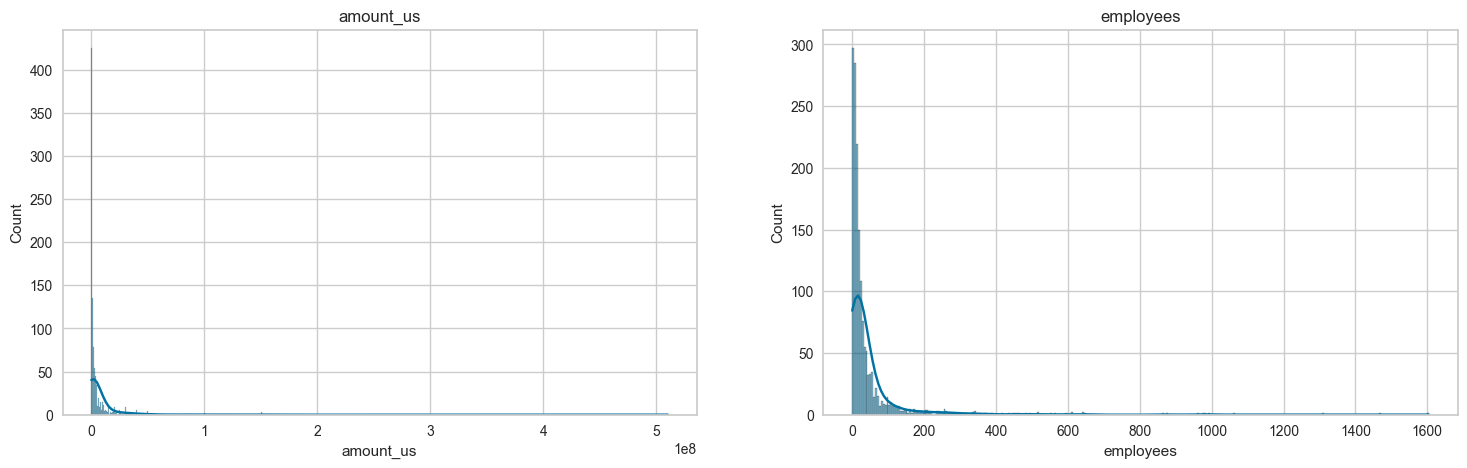

In [138]:
# Visual Distribution of numerical columns values
discol = ['amount_us', 'employees']

# Set up dimensions
columns_per_row = 2
num_columns = len(discol)
num_rows = math.ceil(num_columns/columns_per_row)
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(18, 5 * num_rows))
axes = axes.flatten()

# Visualizaiton parameters
for i, col in enumerate(discol):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
  fig.delaxes(axes[j])

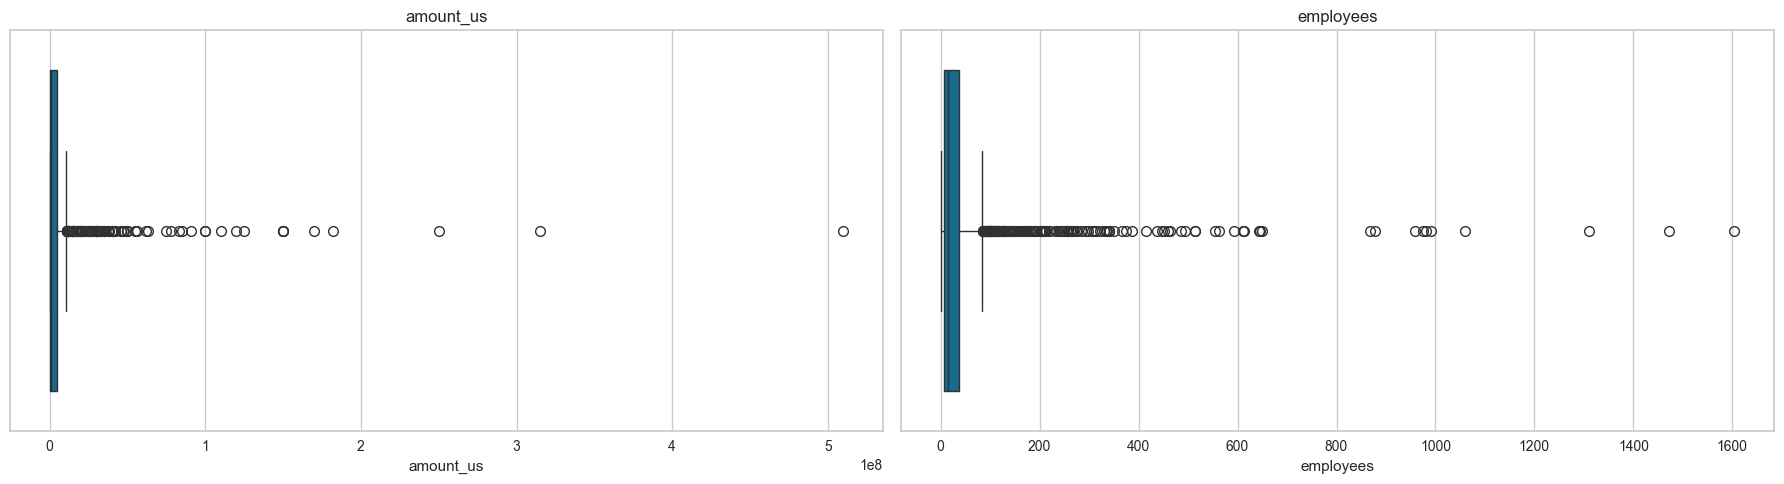

In [139]:
columns_per_row = 2
num_columns = len(discol)
num_rows = math.ceil(num_columns / columns_per_row)

fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for ax, col in zip(axes, discol):
    sns.boxplot(x=df2[col], ax=ax)
    ax.set_title(col)

for j in range(len(discol), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [140]:
# Let's look at the outliers
Amount_Outliers = df2[(df2['amount_us'] > 100000000)]
Amount_Outliers

,startup,location,sector,amount_us,investors,stage,debt_equity,female_co_founder_ceo,local_founder,intnl_founder,launched,accelerator,employees,funding_year
18,Flutterwave,Nigeria,Finance & Fintech,170000000.0,"Avenir Growth Capital, Tiger Global, DST Globa...",Series C,Equity,False,True,False,2016,False,322.0,2021
88,MNT-Halan,Egypt,Finance & Fintech,120000000.0,"Apis Growth Fund II, Development Partners Inte...",Undisclosed,Equity,False,True,False,2018,False,246.0,2021
249,TradeDepot,Nigeria,E-commerce & Retail,110000000.0,"International Finance Corporation (IFC), with ...",Series B,Equity/Debt,False,True,False,2016,False,247.0,2021
572,Moove,Nigeria,Finance & Fintech,181800000.0,"NBK Capital Partners (February), Speedinvest, ...",Undisclosed,Equity/Debt,False,False,True,2019,False,180.0,2022
576,Flutterwave,Nigeria,Finance & Fintech,250000000.0,"Led by B Capital Group, the US$250 million Ser...",Series D,Equity,False,True,False,2016,False,459.0,2022
663,MNT-Halan,Egypt,Finance & Fintech,150000000.0,Commercial International Bank,Undisclosed,Debt,False,True,False,2018,False,98.0,2022
825,Wasoko,Kenya,E-commerce & Retail,125000000.0,"Tiger Global, the worlds largest venture capi...",Series B,Equity,False,False,True,2016,True,645.0,2022
1183,Yassir,Algeria,Technology & AI,150000000.0,"BOND, with participation from DN Capital, Dors...",Series B,Equity,False,True,False,2017,True,649.0,2022
1205,MNT-Halan,Egypt,Finance & Fintech,510000000.0,"Chimera Abu Dhabi, Commercial International Ba...",Undisclosed,Equity/Debt,False,True,False,2018,False,274.0,2023
1490,Sun King (Greenlight Planet),Kenya,Energy & Environment,150000000.0,"British International Investment (ex CDC), Sta...",Undisclosed,Debt,False,True,False,2007,False,1604.0,2023


In [141]:
# Filter out rows where 'employees' is greater than 750
Employees_Outlier = df2[(df2['employees'] > 750)]
Employees_Outlier

,startup,location,sector,amount_us,investors,stage,debt_equity,female_co_founder_ceo,local_founder,intnl_founder,launched,accelerator,employees,funding_year
658,Paymob,Egypt,Finance & Fintech,50000000.0,"led by PayPal Ventures, Kora Capital, and Clay...",Series B,Equity,False,True,False,2015,True,959.0,2022
691,Watu Credit,Kenya,Finance & Fintech,7000000.0,Verdant Capital,Undisclosed,Equity,False,True,False,2015,False,1310.0,2022
787,MaxAB,Egypt,E-commerce & Retail,40000000.0,"Silver Lake, British International Investment ...",Pre-Series B,Equity,False,True,False,2018,True,1060.0,2022
978,M-KOPA,Kenya,Energy & Environment,75000000.0,Generation Investment Management and Broadscal...,Undisclosed,Equity,False,False,True,2011,False,1471.0,2022
1017,Swvl,Egypt,Logistics & Transport,21500000.0,European Bank for Reconstruction and Developme...,Undisclosed,Equity,False,True,False,2017,True,981.0,2022
1336,Copia Global,Kenya,E-commerce & Retail,20000000.0,"Enza Capital, LGT, Goodwell Investments, U.S. ...",Series C,Equity,True,False,True,2010,False,878.0,2023
1446,Apollo Agriculture,Kenya,Agriculture & Agri-tech,NaN,NaN,Undisclosed,Equity,False,True,True,2016,False,868.0,2023
1462,Twiga Foods,Kenya,Agriculture & Agri-tech,35000000.0,"Creadev, Juven, TLCom Capital, DOB Equity",Undisclosed,Equity,False,True,False,2014,False,991.0,2023
1490,Sun King (Greenlight Planet),Kenya,Energy & Environment,150000000.0,"British International Investment (ex CDC), Sta...",Undisclosed,Debt,False,True,False,2007,False,1604.0,2023
1492,d.light,Kenya,Energy & Environment,30130000.0,"Lendahand (February), Swedfund (April), Lendah...",Undisclosed,Equity/Debt,True,True,False,2007,False,975.0,2023


In [142]:
# Examine distribution of Categorical and Boolean Columns
df2.describe(include=['category','bool'])

,location,sector,stage,debt_equity,female_co_founder_ceo,local_founder,intnl_founder,launched,accelerator,funding_year
count,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603
unique,33,23,12,3,2,2,2,19,2,3
top,Nigeria,Finance & Fintech,Undisclosed,Equity,False,True,False,2021,False,2022
freq,465,517,840,1509,1245,1489,1408,321,862,633


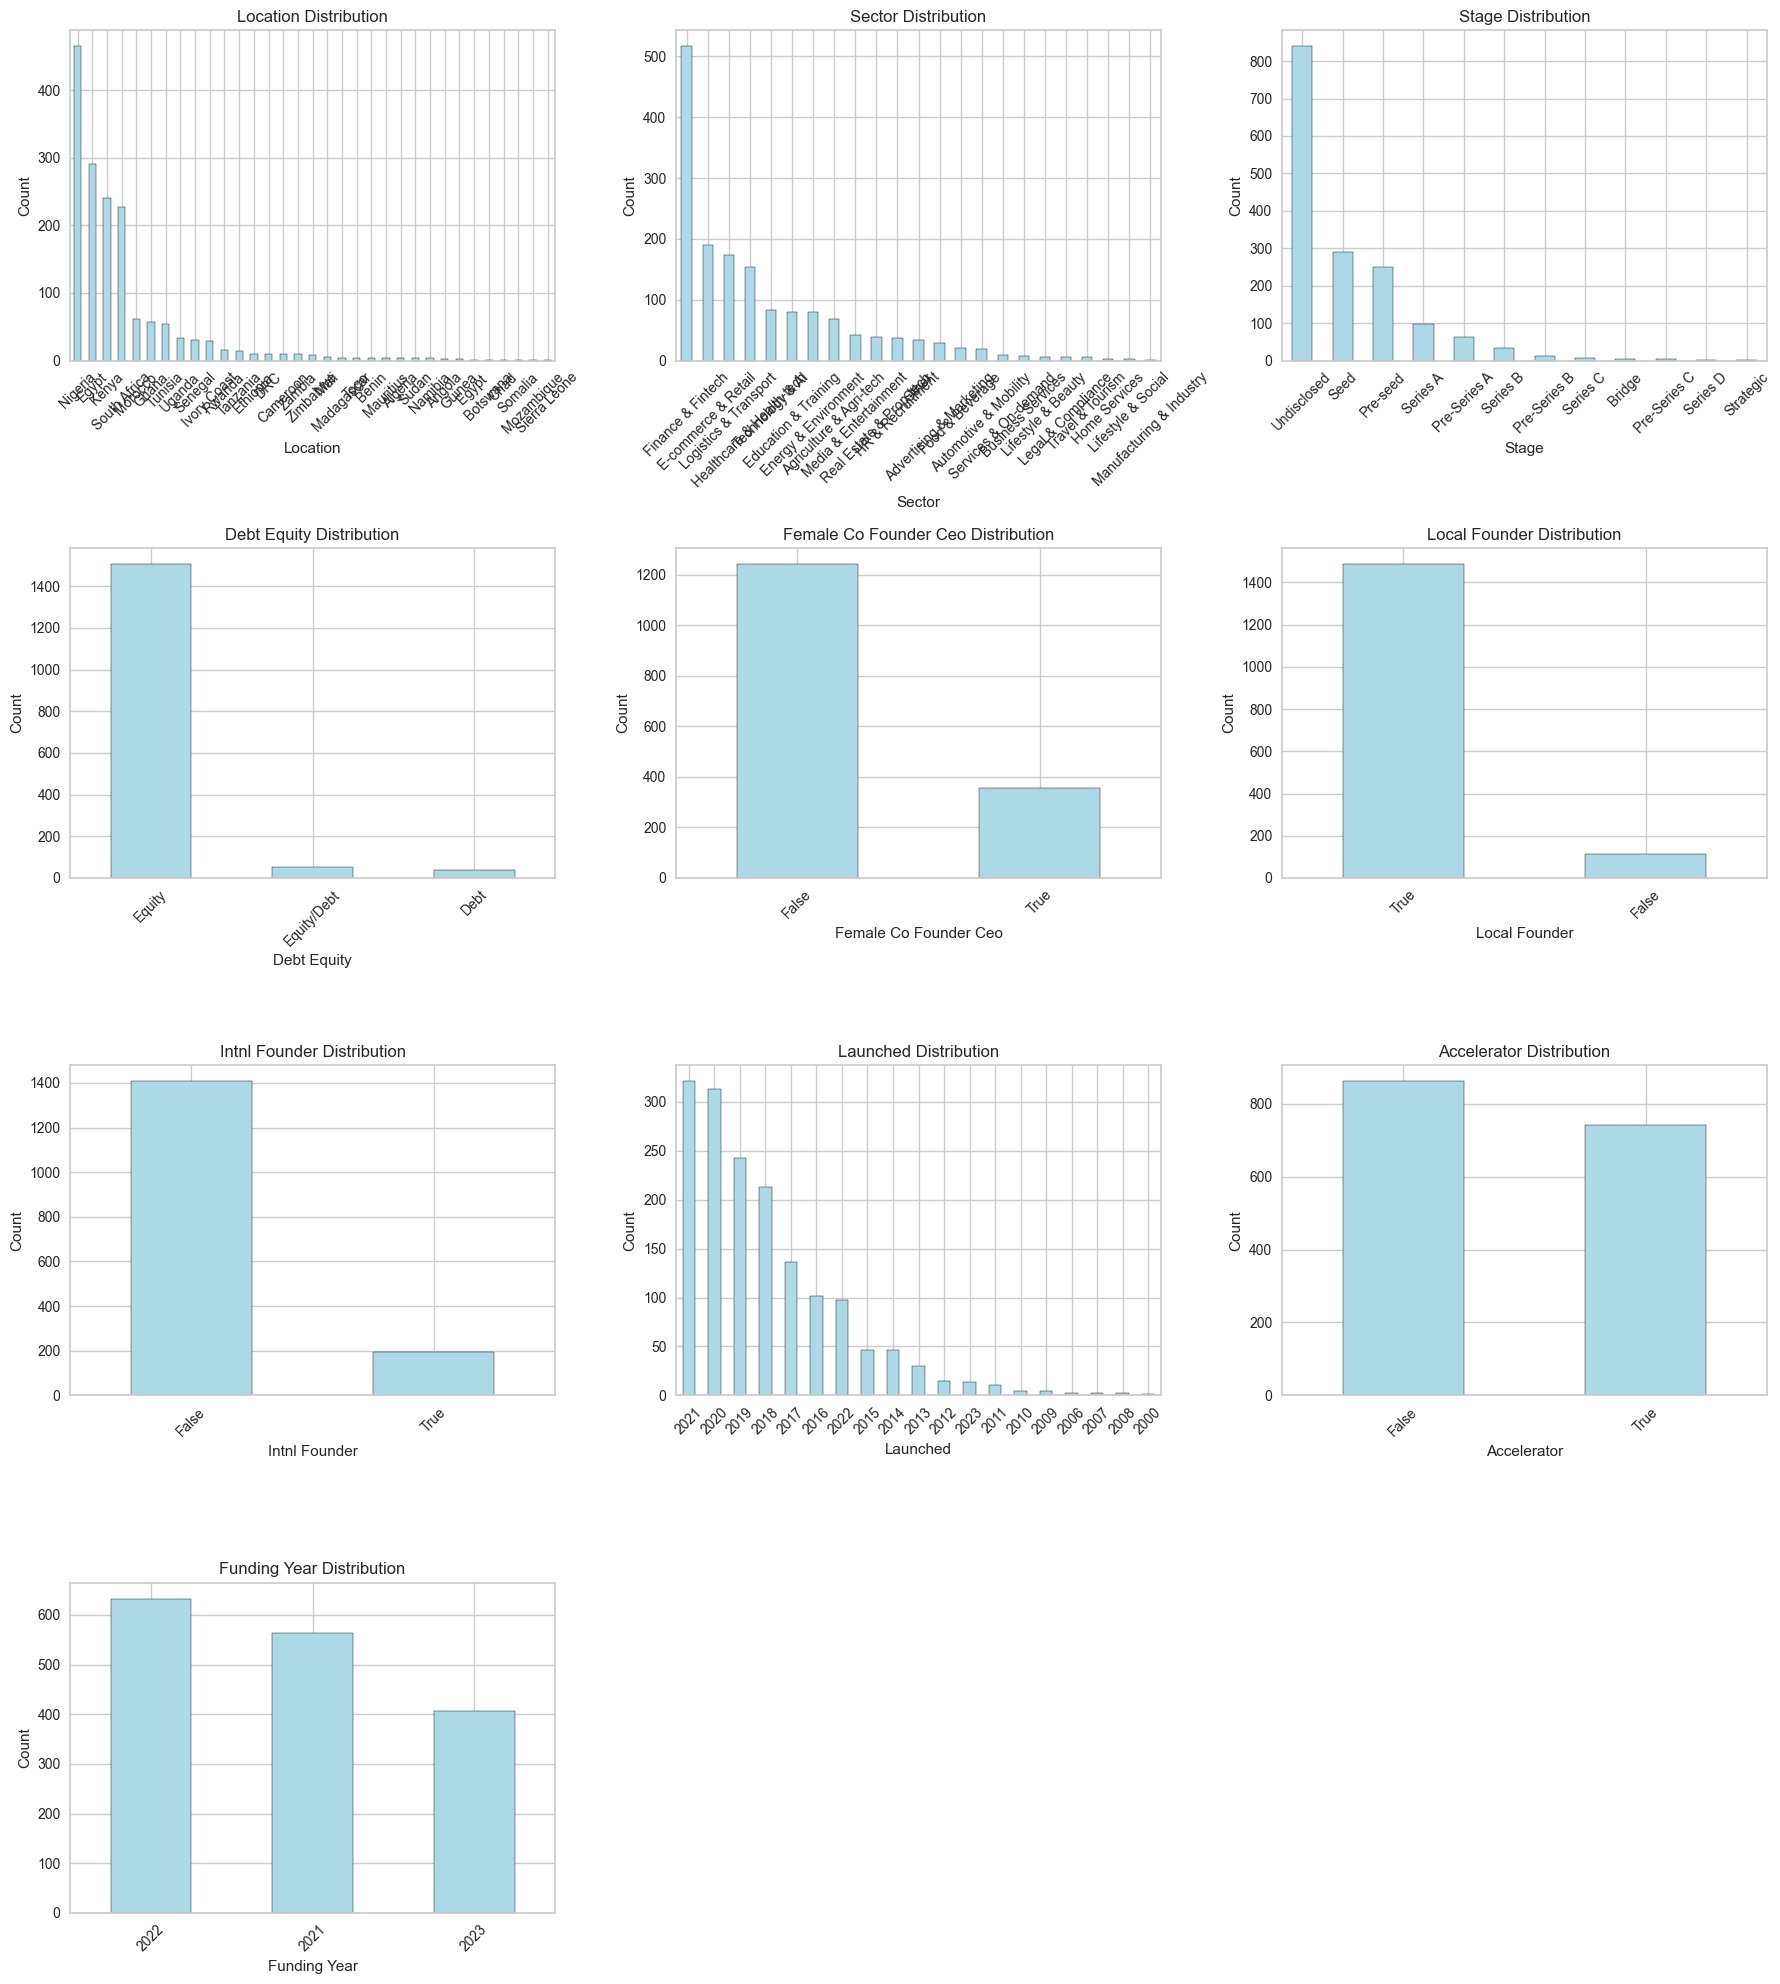

In [143]:
categorical_columns = df2.select_dtypes(include=['category', 'bool']).columns

# Identify parameters for overarching plot
columns_per_row = 3
num_columns = len(categorical_columns)
num_rows = math.ceil(num_columns / columns_per_row)
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(18, 5 * num_rows))
axes = axes.flatten()

# Create a bar plot for each categorical column
for i, col in enumerate(categorical_columns):
    # Count occurrences in the categorical column
    counts = df2[col].value_counts()

    # Plot a bar chart
    counts.plot(kind='bar', ax=axes[i], color='lightblue', edgecolor='black')

    # Set plot titles and labels
    axes[i].set_title(f'{col.replace("_", " ").title()} Distribution')
    axes[i].set_xlabel(col.replace('_', ' ').title())
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused axes if the number of columns is less than the grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Correlation Examination

In [144]:
encoded_df2 = df2.copy()

# Encode boolean columns as integers
boolean_columns = encoded_df2.select_dtypes(include=['bool']).columns
encoded_df2[boolean_columns] = encoded_df2[boolean_columns].astype(int)

# Encode categorical columns using LabelEncoder
categorical_columns = encoded_df2.select_dtypes(include=['category', 'object']).columns

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    encoded_df2[col] = le.fit_transform(encoded_df2[col].astype(str))  # Convert to strings and encode
    label_encoders[col] = le  # Store encoders for potential inverse transformation

# Compute the correlation matrix with encoded data
correlation_matrix = encoded_df2.corr()

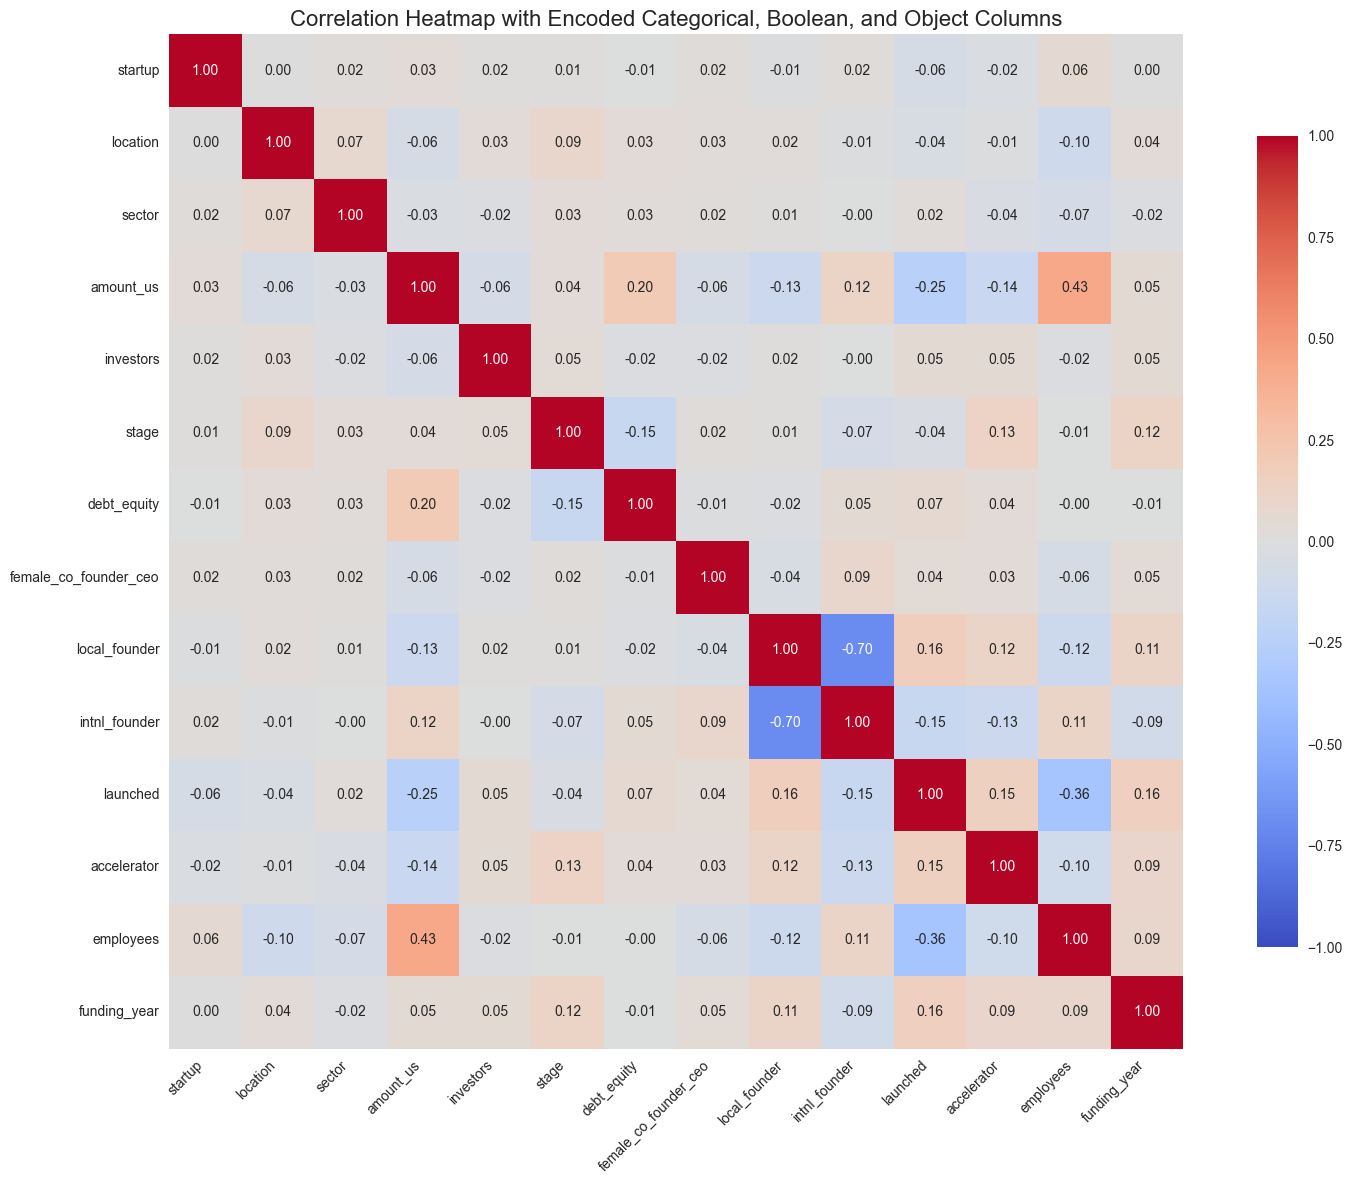

In [145]:
# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            square=True,
            vmin=-1,
            vmax=1,
            cbar_kws={"shrink": .8},
            annot_kws={"size": 10})
plt.title('Correlation Heatmap with Encoded Categorical, Boolean, and Object Columns', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Addressing Missing Data

Due to the absence of strong bilateral relationships, we will proceed with addressing missing data without utilizing correlation.

In [146]:
missing_data = df2.isnull().sum()

# Percentage of missing values
missing_percentage = (df2.isnull().sum() / len(df2)) * 100

# Display missing data summary
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage': missing_percentage})
print(missing_summary)

                       Missing Count  Missing Percentage
startup                            0            0.000000
location                           0            0.000000
sector                             0            0.000000
amount_us                        619           38.615097
investors                         64            3.992514
stage                              0            0.000000
debt_equity                        0            0.000000
female_co_founder_ceo              0            0.000000
local_founder                      0            0.000000
intnl_founder                      0            0.000000
launched                           0            0.000000
accelerator                        0            0.000000
employees                          1            0.062383
funding_year                       0            0.000000


In [147]:
# Replace NaN values in the 'investors' column with "NA"
df2['investors'] = df2['investors'].fillna("Unknown")
# Replace 'n.a.' values in the 'investors' column with "Unknown"
df2['investors'] = df2['investors'].replace('n.a.', 'Unknown')
# Replace NaN value in the 'employees' column with the most appropriate central tendency measure, the median since data is skewed
df2['employees'] = df2['employees'].fillna(df2['employees'].median())

In [148]:
# Prepare data
train_data = df2[df2['amount_us'].notnull()]
test_data = df2[df2['amount_us'].isnull()]

X_train = train_data.drop(columns=['amount_us'])
y_train = train_data['amount_us']
X_test = test_data.drop(columns=['amount_us'])

# Encode categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict missing values
df2.loc[df2['amount_us'].isnull(), 'amount_us'] = model.predict(X_test)

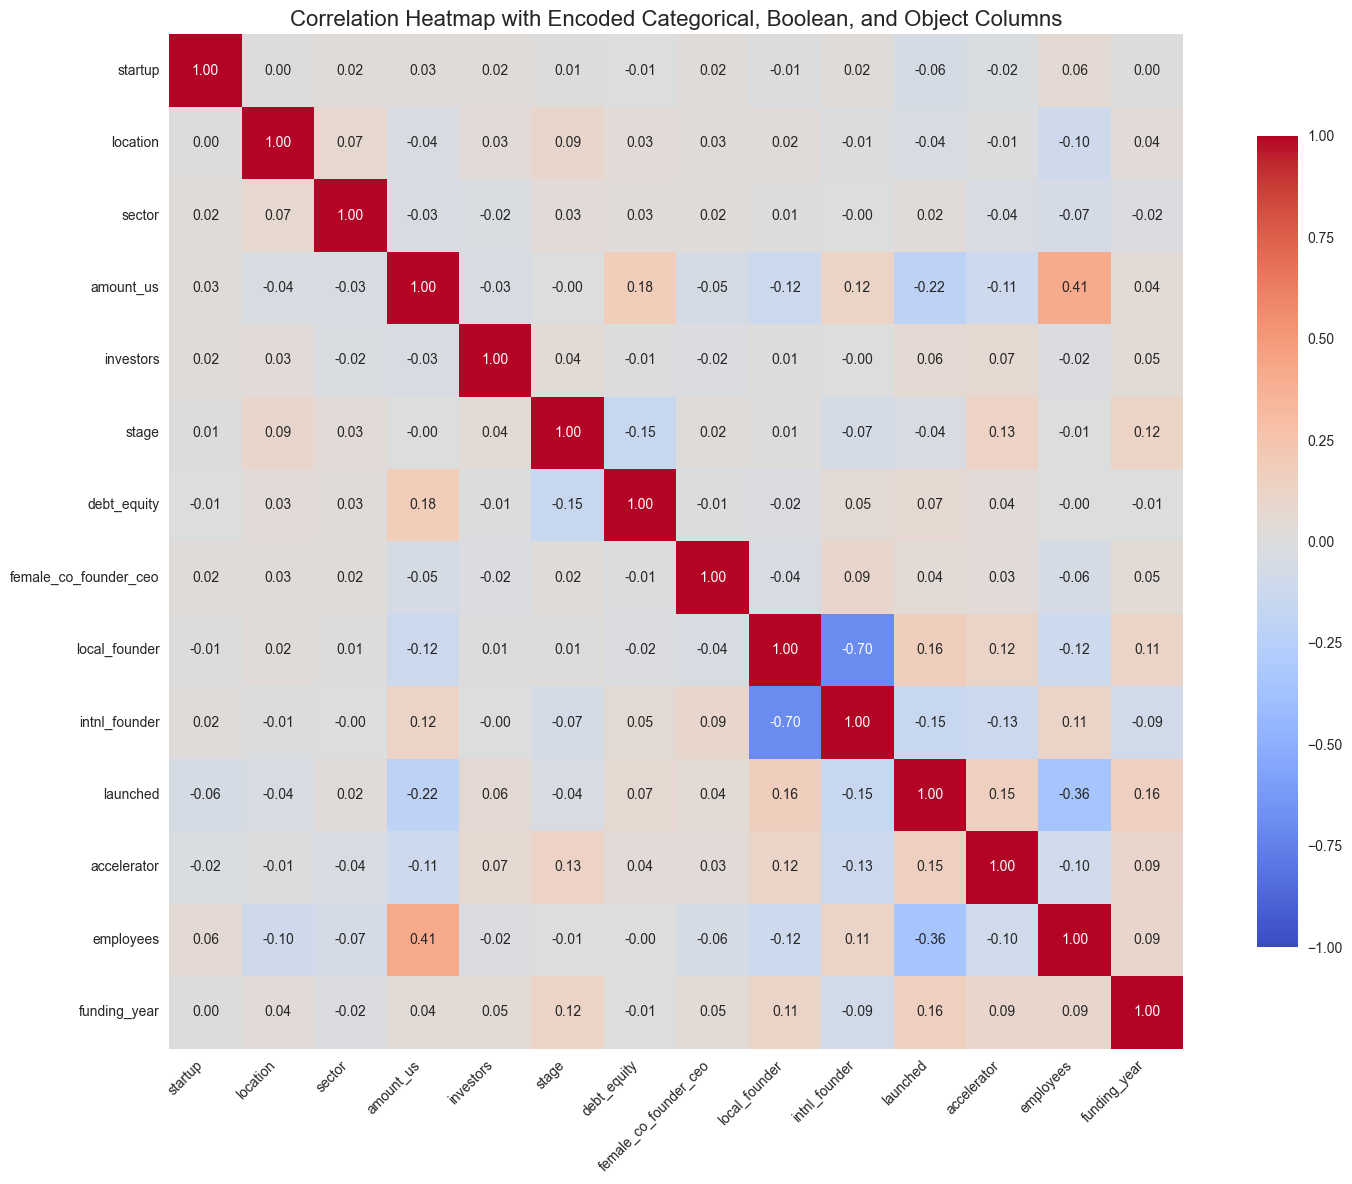

In [149]:
encoded_df2 = df2.copy()

# Encode boolean columns as integers
boolean_columns = encoded_df2.select_dtypes(include=['bool']).columns
encoded_df2[boolean_columns] = encoded_df2[boolean_columns].astype(int)

# Encode categorical columns using LabelEncoder
categorical_columns = encoded_df2.select_dtypes(include=['category', 'object']).columns

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    encoded_df2[col] = le.fit_transform(encoded_df2[col].astype(str))  # Convert to strings and encode
    label_encoders[col] = le  # Store encoders for potential inverse transformation

# Compute the correlation matrix with encoded data
correlation_matrix = encoded_df2.corr()
# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            square=True,
            vmin=-1,
            vmax=1,
            cbar_kws={"shrink": .8},
            annot_kws={"size": 10})
plt.title('Correlation Heatmap with Encoded Categorical, Boolean, and Object Columns', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [150]:
missing_data = df2.isnull().sum()

# Percentage of missing values
missing_percentage = (df2.isnull().sum() / len(df2)) * 100

# Display missing data summary
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage': missing_percentage})
print(missing_summary)

                       Missing Count  Missing Percentage
startup                            0                 0.0
location                           0                 0.0
sector                             0                 0.0
amount_us                          0                 0.0
investors                          0                 0.0
stage                              0                 0.0
debt_equity                        0                 0.0
female_co_founder_ceo              0                 0.0
local_founder                      0                 0.0
intnl_founder                      0                 0.0
launched                           0                 0.0
accelerator                        0                 0.0
employees                          0                 0.0
funding_year                       0                 0.0


## Save Clean Data to SQL library

After cleaning the data we can transmit it to SSMS as a table in the Africa_Tech_Startups database using SQL alchemy

In [151]:
# Save the cleaned data to an Excel file
output_filepath = 'C:/Users/abdel/OneDrive/Dokumente/GitHub/disrupt-africa/Funded_African_Tech_Startups_Clean.xlsx'
df2.to_excel(output_filepath, index=False)

In [153]:
# Start here with feature importance

## Regression Analysis

Now we have clean data, we can move into doing some econometrics. Since we are working on funding of the year 2023, we need to be very careful about the direction of causality. and interpreting the results.

## 1. Direct Impact

In [152]:
# 1.A. Economic Impact
# Relationship to Explore: How does Amount (US$) influence Employees?

categorical_vars = ['Sector', 'Location']
numeric_vars = ['Amount_USD']

# Preprocessing categorical variables
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = pd.DataFrame(ohe.fit_transform(df2[categorical_vars]), columns=ohe.get_feature_names_out(categorical_vars))

# Combine processed categorical and numeric variables
X = pd.concat([encoded_cats, df2[numeric_vars].reset_index(drop=True)], axis=1)

# Add a constant for the regression model
X = sm.add_constant(X)

# Define the dependent variable
y = df2['Employees']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

KeyError: "None of [Index(['Sector', 'Location'], dtype='object')] are in the [columns]"

In [ ]:
# 1.B. Startup Maturity and Employment

categorical_vars = ['Sector', 'Location']
numeric_vars = ['Amount (US$)', 'Launched?']

# Preprocessing categorical variables
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = pd.DataFrame(ohe.fit_transform(df2[categorical_vars]), columns=ohe.get_feature_names_out(categorical_vars))

# Combine processed categorical and numeric variables
X = pd.concat([encoded_cats, df2[numeric_vars].reset_index(drop=True)], axis=1)

# Add a constant for the regression model
X = sm.add_constant(X)

# Define the dependent variable
y = df2['Employees']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

KeyError: "None of [Index(['Amount (US$)', 'Launched?'], dtype='object')] are in the [columns]"

In [ ]:
# Preprocessing categorical variables
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = pd.DataFrame(ohe.fit_transform(df2[categorical_vars]), columns=ohe.get_feature_names_out(categorical_vars))

# Combine processed categorical and numeric variables
X = pd.concat([encoded_cats, df2[numeric_vars].reset_index(drop=True)], axis=1)

# Add a constant for the regression model
X = sm.add_constant(X)

# Define the dependent variable
y = df2['Employees']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Employees   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     3.326
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           5.98e-11
Time:                        23:33:14   Log-Likelihood:                -2506.5
No. Observations:                 406   AIC:                             5111.
Df Residuals:                     357   BIC:                             5307.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [ ]:
# 1.C. Stage and Employment
# Variables to include in the model
categorical_vars = ['Sector', 'Location', 'Stage']
numeric_vars = ['Amount (US$)', 'Launched?']

# Preprocessing categorical variables
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = pd.DataFrame(ohe.fit_transform(df2[categorical_vars]), columns=ohe.get_feature_names_out(categorical_vars))

# Combine processed categorical and numeric variables
X = pd.concat([encoded_cats, df2[numeric_vars].reset_index(drop=True)], axis=1)

# Add a constant for the regression model
X = sm.add_constant(X)

# Define the dependent variable
y = df2['Employees']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Employees   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     3.467
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           8.70e-13
Time:                        23:33:14   Log-Likelihood:                -2491.7
No. Observations:                 406   AIC:                             5097.
Df Residuals:                     349   BIC:                             5326.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

## 2. Inclusivity Metrics

In [ ]:
# 2.A.1 Does having a Female co-founder or Female CEO affect the Amount (US$) raised?

# Convert Boolean Values to integers for regression
df2['Female co-founder?'] = df2['Female co-founder?'].astype(int)
df2['Female CEO?'] = df2['Female CEO?'].astype(int)

threshold = 1_000_000
df2['High_Funding'] = (df2['Amount (US$)'] > threshold).astype(int)

# Define independent variables
X_gender = df2[['Female co-founder?', 'Female CEO?']]
X_gender = sm.add_constant(X_gender)  # Add constant

# Define dependent variable
y_high_funding = df2['High_Funding']

# Fit logistic regression model
logit_model = sm.Logit(y_high_funding, X_gender).fit()

# Print the summary
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.690251
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           High_Funding   No. Observations:                  406
Model:                          Logit   Df Residuals:                      403
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Dec 2024   Pseudo R-squ.:                0.003742
Time:                        23:33:14   Log-Likelihood:                -280.24
converged:                       True   LL-Null:                       -281.29
Covariance Type:            nonrobust   LLR p-value:                    0.3490
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0094      0.116      0.082      0.935      -0.217       0.236
Femal

In [ ]:
# 2.A.2 Do startups led by Female co-founders or Female CEOs employ more Employees?

# Define independent variables
X_employment_gender = df2[['Female co-founder?', 'Female CEO?']]
X_employment_gender = sm.add_constant(X_employment_gender)  # Add constant

# Define dependent variable
y_employees = df2['Employees']

# Fit OLS regression model
ols_model_gender = sm.OLS(y_employees, X_employment_gender).fit()

# Print the summary
print(ols_model_gender.summary())

                            OLS Regression Results                            
Dep. Variable:              Employees   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7461
Date:                Fri, 13 Dec 2024   Prob (F-statistic):              0.475
Time:                        23:33:14   Log-Likelihood:                -2580.8
No. Observations:                 406   AIC:                             5168.
Df Residuals:                     403   BIC:                             5180.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 63.0741      8

In [ ]:
# 2.B.1 How do Local founders or International founders impact Amount (US$)?
# Change Boolian values to Integer for regrssion
df2['Local founder?'] = df2['Local founder?'].astype(int)
df2['Intnl founder?'] = df2['Intnl founder?'].astype(int)

# Define independent variables
X_funding_founders = df2[['Local founder?', 'Intnl founder?']]
X_funding_founders = sm.add_constant(X_funding_founders)  # Add constant

# Define dependent variable
y_funding = df2['Amount (US$)']

# Fit OLS regression model
ols_model_funding_founders = sm.OLS(y_funding, X_funding_founders).fit()

# Print the summary
print(ols_model_funding_founders.summary())

                            OLS Regression Results                            
Dep. Variable:           Amount (US$)   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     6.842
Date:                Fri, 13 Dec 2024   Prob (F-statistic):            0.00120
Time:                        23:33:14   Log-Likelihood:                -7582.9
No. Observations:                 406   AIC:                         1.517e+04
Df Residuals:                     403   BIC:                         1.518e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.913e+07   9.99e+06      2.

In [ ]:
# 2.B.2 How do Local founders or International founders impact Employees?

# Define independent variables
X_employment_founders = df2[['Local founder?', 'Intnl founder?']]
X_employment_founders = sm.add_constant(X_employment_founders)  # Add constant

# Define dependent variable
y_employees = df2['Employees']

# Fit OLS regression model
ols_model_employment_founders = sm.OLS(y_employees, X_employment_founders).fit()

# Print the summary
print(ols_model_employment_founders.summary())

                            OLS Regression Results                            
Dep. Variable:              Employees   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.953
Date:                Fri, 13 Dec 2024   Prob (F-statistic):              0.143
Time:                        23:33:14   Log-Likelihood:                -2579.6
No. Observations:                 406   AIC:                             5165.
Df Residuals:                     403   BIC:                             5177.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             78.5166     44.434      1.

## 3. Market Creation Effects

In [ ]:
# 3.A. Sector and Ecosystem Growth

sector_ohe = OneHotEncoder(drop='first', sparse_output=False)
sector_encoded = pd.DataFrame(sector_ohe.fit_transform(df2[['Sector']]), columns=sector_ohe.get_feature_names_out(['Sector']))

# Independent variables for regression
X_sector = pd.concat([sector_encoded, df2[['Amount (US$)']].reset_index(drop=True)], axis=1)
X_sector = sm.add_constant(X_sector)  # Add constant

# Dependent variable: Employees
y_employees = df2['Employees']

# Fit OLS model
sector_model_employees = sm.OLS(y_employees, X_sector).fit()
print("Sector and Employees Model Summary:")
print(sector_model_employees.summary())

Sector and Employees Model Summary:
                            OLS Regression Results                            
Dep. Variable:              Employees   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     2.973
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           1.15e-05
Time:                        23:33:14   Log-Likelihood:                -2549.5
No. Observations:                 406   AIC:                             5145.
Df Residuals:                     383   BIC:                             5237.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [ ]:
# 3.B. Accelerator Participation
# Ensure the Accelerator? column is numeric
df2['Accelerator?'] = df2['Accelerator?'].astype(int)

# Independent variables for Accelerator participation
X_accelerator = df2[['Accelerator?']]
X_accelerator = sm.add_constant(X_accelerator)  # Add constant

# Dependent variable: Amount (US$)
y_amount = df2['Amount (US$)']

# Fit OLS model for funding
accelerator_model_funding = sm.OLS(y_amount, X_accelerator).fit()
print("Accelerator and Funding Model Summary:")
print(accelerator_model_funding.summary())

# Dependent variable: Employees
y_employees = df2['Employees']

# Fit OLS model for employment
accelerator_model_employees = sm.OLS(y_employees, X_accelerator).fit()
print("Accelerator and Employees Model Summary:")
print(accelerator_model_employees.summary())

Accelerator and Funding Model Summary:
                            OLS Regression Results                            
Dep. Variable:           Amount (US$)   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     7.642
Date:                Fri, 13 Dec 2024   Prob (F-statistic):            0.00596
Time:                        23:33:14   Log-Likelihood:                -7585.9
No. Observations:                 406   AIC:                         1.518e+04
Df Residuals:                     404   BIC:                         1.518e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const    

## 4. Additional Investigation

In [ ]:
# 4.A. Debt vs. Equity Impact

# One-hot encode Debt/Equity
funding_type_ohe = OneHotEncoder(drop='first', sparse_output=False)
funding_type_encoded = pd.DataFrame(funding_type_ohe.fit_transform(df2[['Debt/Equity']]), columns=funding_type_ohe.get_feature_names_out(['Debt/Equity']))

# Independent variables for funding type
X_funding_type = pd.concat([funding_type_encoded], axis=1)
X_funding_type = sm.add_constant(X_funding_type)  # Add constant

# Dependent variable: Employees
y_employees = df2['Employees']

# Fit OLS model for employment
funding_type_model_employees = sm.OLS(y_employees, X_funding_type).fit()
print("Funding Type and Employees Model Summary:")
print(funding_type_model_employees.summary())

# Dependent variable: Amount (US$)
y_amount = df2['Amount (US$)']

# Fit OLS model for funding
funding_type_model_funding = sm.OLS(y_amount, X_funding_type).fit()
print("Funding Type and Funding Model Summary:")
print(funding_type_model_funding.summary())

Funding Type and Employees Model Summary:
                            OLS Regression Results                            
Dep. Variable:              Employees   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     14.91
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           5.64e-07
Time:                        23:33:14   Log-Likelihood:                -2567.0
No. Observations:                 406   AIC:                             5140.
Df Residuals:                     403   BIC:                             5152.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [ ]:
# 4.B. Geographic Factors

# One-hot encode Location
location_ohe = OneHotEncoder(drop='first', sparse_output=False)
location_encoded = pd.DataFrame(location_ohe.fit_transform(df2[['Location']]), columns=location_ohe.get_feature_names_out(['Location']))

# Independent variables for Location
X_location = pd.concat([location_encoded], axis=1)
X_location = sm.add_constant(X_location)  # Add constant

# Dependent variable: Employees
y_employees = df2['Employees']

# Fit OLS model for employment
location_model_employees = sm.OLS(y_employees, X_location).fit()
print("Location and Employees Model Summary:")
print(location_model_employees.summary())

# Dependent variable: Amount (US$)
y_amount = df2['Amount (US$)']

# Fit OLS model for funding
location_model_funding = sm.OLS(y_amount, X_location).fit()
print("Location and Funding Model Summary:")
print(location_model_funding.summary())

Location and Employees Model Summary:
                            OLS Regression Results                            
Dep. Variable:              Employees   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.9042
Date:                Fri, 13 Dec 2024   Prob (F-statistic):              0.600
Time:                        23:33:14   Log-Likelihood:                -2569.8
No. Observations:                 406   AIC:                             5192.
Df Residuals:                     380   BIC:                             5296.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------